# Rt profile Multiple group versus uniform

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

num_timepoints = 250 # number of days for incidence data
num_categories = 2

# Same generation time interval

## Parameterize example branching process model with disagregated data

In [2]:
# Build the generation time interval w_s
serial_intervals = []

ws_mean_cat = [5.3, 5.3]
ws_std_cat = [2.3, 2.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(30))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[4, .4], [.6, 8.]]),
    np.array([[6, 8.], [4, .4]]),
    np.array([[4, .4], [.6, 8.]]),
    np.array([[4, .4], [.6, 8.]])
    ]

new_rs = [
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.2, 0.1],
    [0.35, 0.05, 0.4, 0.05]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00]
 [1.00000000e+01 1.00000000e+01]
 [7.00000000e+00 2.10000000e+01]
 [2.40000000e+01 2.80000000e+01]
 [2.50000000e+01 4.00000000e+01]
 [2.50000000e+01 2.50000000e+01]
 [1.70000000e+01 4.70000000e+01]
 [1.70000000e+01 5.50000000e+01]
 [2.20000000e+01 5.00000000e+01]
 [3.00000000e+01 5.90000000e+01]
 [3.20000000e+01 7.00000000e+01]
 [2.80000000e+01 9.50000000e+01]
 [3.80000000e+01 1.19000000e+02]
 [4.60000000e+01 1.30000000e+02]
 [4.80000000e+01 1.55000000e+02]
 [4.10000000e+01 1.72000000e+02]
 [3.80000000e+01 2.11000000e+02]
 [5.80000000e+01 2.72000000e+02]
 [7.30000000e+01 3.27000000e+02]
 [7.90000000e+01 3.97000000e+02]
 [8.80000000e+01 4.15000000e+02]
 [1.06000000e+02 5.40000000e+02]
 [9.40000000e+01 6.30000000e+02]
 [1.17000000e+02 7.77000000e+02]
 [1.50000000e+02 8.99000000e+02]
 [1.75000000e+02 1.04100000e+03]
 [1.72000000e+02 1.35600000e+03]
 [2.48000000e+02 1.54100000e+03]
 [2.440000

In [3]:
serial_intervals[0, :]

array([0.00000000e+00, 9.58800666e-03, 6.98325409e-02, 1.47197029e-01,
       1.86754858e-01, 1.79407436e-01, 1.44543196e-01, 1.03139288e-01,
       6.73372012e-02, 4.10778728e-02, 2.37524351e-02, 1.31521254e-02,
       7.02667551e-03, 3.64300510e-03, 1.84103022e-03, 9.10096666e-04,
       4.41343157e-04, 2.10445269e-04, 9.88584569e-05, 4.58249859e-05,
       2.09893296e-05, 9.51063233e-06, 4.26747430e-06, 1.89784633e-06,
       8.37161827e-07, 3.66526419e-07, 1.59368998e-07, 6.88543515e-08,
       2.95726013e-08, 1.26316074e-08])

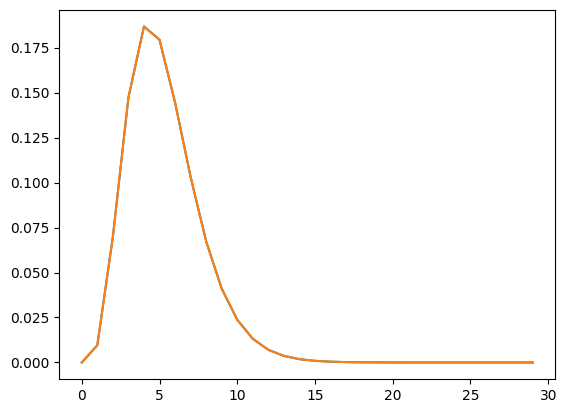

In [4]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [5]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [6]:
spec_radius = []
stability_criterion = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_])

0.40295630140987004 8.0591260281974
0.47559467676119005 9.5118935352238
0.8059126028197401 8.0591260281974
0.40295630140987004 8.0591260281974


In [7]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [8]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
    L3 = len(np.arange(start_times[2]+1, start_times[3]+1))
    L4 = len(np.arange(start_times[3]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2 + [new_rs[_][2]*correc_i[_]] * L3 + [new_rs[_][3]*correc_i[_]] * L4
    }))

## Divergence of Means

In [9]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multiple group versus One group model')

    fig.show_figure()

In [10]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed γ<sub>t</sub>', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Same generation time interval', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis2=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis2=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis3=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis3=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis4=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis4=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_same_SI.pdf')
fig.show()

# Different generation time intervals

## Parameterize example branching process model with disagregated data

In [11]:
# Build the generation time interval w_s
serial_intervals = []

ws_mean_cat = [5.3, 7]
ws_std_cat = [2.3, 2.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(30))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[4, .4], [.6, 8.]]),
    np.array([[6, 8.], [4, .4]]),
    np.array([[4, .4], [.6, 8.]]),
    np.array([[4, .4], [.6, 8.]])
    ]

new_rs = [
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.2, 0.1],
    [0.35, 0.05, 0.4, 0.05]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [4.00000000e+00 1.00000000e+00]
 [8.00000000e+00 4.00000000e+00]
 [1.40000000e+01 2.10000000e+01]
 [1.90000000e+01 2.50000000e+01]
 [9.00000000e+00 3.60000000e+01]
 [1.20000000e+01 3.40000000e+01]
 [1.30000000e+01 2.80000000e+01]
 [1.10000000e+01 2.40000000e+01]
 [1.80000000e+01 2.90000000e+01]
 [1.60000000e+01 3.50000000e+01]
 [1.60000000e+01 5.30000000e+01]
 [2.70000000e+01 6.50000000e+01]
 [2.00000000e+01 8.10000000e+01]
 [2.70000000e+01 7.10000000e+01]
 [2.90000000e+01 8.00000000e+01]
 [3.40000000e+01 1.18000000e+02]
 [3.70000000e+01 9.10000000e+01]
 [4.60000000e+01 1.40000000e+02]
 [4.90000000e+01 1.50000000e+02]
 [4.00000000e+01 1.80000000e+02]
 [5.00000000e+01 2.01000000e+02]
 [5.90000000e+01 2.39000000e+02]
 [6.60000000e+01 2.71000000e+02]
 [7.60000000e+01 3.17000000e+02]
 [7.80000000e+01 3.49000000e+02]
 [8.20000000e+01 4.08000000e+02]
 [1.02000000e+02 4.49000000e+02]
 [1.070000

In [12]:
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Scatter(
        x=times,
        y=serial_intervals[0, :] / np.sum(serial_intervals[0, :]),
        name='Group 1',
        mode='markers',
        marker_color='blue',
        marker_size=8
    )
)

fig.add_trace(
    go.Scatter(
        x=times,
        y=serial_intervals[1, :] / np.sum(serial_intervals[1, :]),
        name='Group 2',
        mode='markers',
        marker_color='orange',
        marker_symbol='diamond',
        marker_size=8
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='Probability'
)

fig.update_layout(
    boxmode='group', 
    width=600,
    height=500,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Probability',
        linecolor='black'),
    legend=dict(
        title='Group generation time intervals',
        yanchor="bottom",
        y=0.75,
        xanchor="right",
        x=1,
        bordercolor="Black", 
        borderwidth=1
    ))

fig.write_image('images/Group_SI_different.pdf')

fig.show()

## Plot agreggated local incidence numbers

In [13]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [14]:
spec_radius = []
stability_criterion = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_])

0.40295630140987004 8.0591260281974
0.47559467676119005 9.5118935352238
0.8059126028197401 8.0591260281974
0.40295630140987004 8.0591260281974


In [15]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [16]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
    L3 = len(np.arange(start_times[2]+1, start_times[3]+1))
    L4 = len(np.arange(start_times[3]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2 + [new_rs[_][2]*correc_i[_]] * L3 + [new_rs[_][3]*correc_i[_]] * L4
    }))

## Divergence of Means

In [17]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multiple group versus One group model')

    fig.show_figure()

In [18]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed γ<sub>t</sub>', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Different generation time intervals', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis2=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis2=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis3=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis3=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis4=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis4=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_dif_SI.pdf')
fig.show()

# Different generation time intervals, cropped

## Parameterize example branching process model with disagregated data

In [19]:
# Build the generation time interval w_s
serial_intervals = []

ws_mean_cat = [5.3, 5.3]
ws_std_cat = [2.3, 2.3]
crop_cat = [30, 5]

for ws_mean, ws_std, crop in zip(ws_mean_cat, ws_std_cat, crop_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(crop))
    disc_w = np.array(disc_w.tolist() + [0]*(30-crop))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[4, .4], [.6, 8.]]),
    np.array([[6, 8.], [4, .4]]),
    np.array([[4, .4], [.6, 8.]]),
    np.array([[4, .4], [.6, 8.]])
    ]

new_rs = [
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.4, 0.05],
    [0.35, 0.05, 0.2, 0.1],
    [0.35, 0.05, 0.4, 0.05]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37, 60, 160]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    # m._normalizing_const[1] *= np.sum(serial_intervals[0,:]) / np.sum(serial_intervals[1,:])
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 5.00000000e+00]
 [5.00000000e+00 1.60000000e+01]
 [1.10000000e+01 5.90000000e+01]
 [1.50000000e+01 6.80000000e+01]
 [1.60000000e+01 2.20000000e+01]
 [1.20000000e+01 4.70000000e+01]
 [1.60000000e+01 1.15000000e+02]
 [2.30000000e+01 1.51000000e+02]
 [2.30000000e+01 1.46000000e+02]
 [2.40000000e+01 1.24000000e+02]
 [2.70000000e+01 2.69000000e+02]
 [4.30000000e+01 3.80000000e+02]
 [3.70000000e+01 4.18000000e+02]
 [6.40000000e+01 5.03000000e+02]
 [8.00000000e+01 6.01000000e+02]
 [9.20000000e+01 9.33000000e+02]
 [8.50000000e+01 1.19900000e+03]
 [1.20000000e+02 1.33100000e+03]
 [1.39000000e+02 1.75900000e+03]
 [2.01000000e+02 2.34300000e+03]
 [2.47000000e+02 3.10200000e+03]
 [3.05000000e+02 4.01100000e+03]
 [3.51000000e+02 4.81800000e+03]
 [4.85000000e+02 6.42200000e+03]
 [6.47000000e+02 8.33500000e+03]
 [8.57000000e+02 1.08790000e+04]
 [1.06300000e+03 1.37990000e+04]
 [1.37100000e+03 1.71520000e+04]
 [1.682000

In [20]:
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Scatter(
        x=times,
        y=serial_intervals[0, :] / np.sum(serial_intervals[0, :]),
        name='Group 1',
        mode='markers',
        marker_color='blue',
        marker_size=8
    )
)

fig.add_trace(
    go.Scatter(
        x=times,
        y=serial_intervals[1, :] / np.sum(serial_intervals[1, :]),
        name='Group 2',
        mode='markers',
        marker_color='orange',
        marker_symbol='diamond',
        marker_size=8s
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='Probability'
)

fig.update_layout(
    boxmode='group', 
    width=600,
    height=500,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Probability',
        linecolor='black'),
    legend=dict(
        title='Group generation time intervals',
        yanchor="bottom",
        y=0.75,
        xanchor="right",
        x=1,
        bordercolor="Black", 
        borderwidth=1
    ))

fig.write_image('images/Group_SI_same_cropped.pdf')

fig.show()

In [21]:
for j in range(m._num_cat):
    print(m.get_serial_intervals()[j, :] / m._normalizing_const[j])
    print(np.sum(m.get_serial_intervals()[j, :] / m._normalizing_const[j]))
    print(m._normalizing_const[j])

[0.00000000e+00 9.58764800e-03 6.98299287e-02 1.47191523e-01
 1.86747872e-01 1.79400725e-01 1.44537789e-01 1.03135430e-01
 6.73346823e-02 4.10763362e-02 2.37515466e-02 1.31516334e-02
 7.02641267e-03 3.64286883e-03 1.84096136e-03 9.10062622e-04
 4.41326648e-04 2.10437397e-04 9.88547589e-05 4.58232717e-05
 2.09885445e-05 9.51027657e-06 4.26731467e-06 1.89777533e-06
 8.37130511e-07 3.66512708e-07 1.59363037e-07 6.88517759e-08
 2.95714951e-08 1.26311348e-08]
0.9999999999999997
1.000037408024706
[0.         0.0231946  0.16893371 0.35608816 0.45178353 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
1.0
0.41337243447159694


## Plot agreggated local incidence numbers

In [22]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [23]:
spec_radius = []
stability_criterion = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_])

0.40295630140987004 8.0591260281974
0.47559467676119005 9.5118935352238
0.8059126028197401 8.0591260281974
0.40295630140987004 8.0591260281974


In [24]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [25]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
    L3 = len(np.arange(start_times[2]+1, start_times[3]+1))
    L4 = len(np.arange(start_times[3]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2 + [new_rs[_][2]*correc_i[_]] * L3 + [new_rs[_][3]*correc_i[_]] * L4
    }))

## Divergence of Means

In [26]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval)
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/(np.sum(serial_intervals[j,:])* np.sum(serial_intervals[0,:]) / np.sum(serial_intervals[j,:]))
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multiple group versus One group model')

    fig.show_figure()

In [27]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed γ<sub>t</sub>', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Same generation time intervals, cropped', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis2=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis2=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis3=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis3=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis4=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis4=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_cropped_SI.pdf')
fig.show()

# Correct average generation time interval

## Parameterize example branching process model with disagregated data

In [28]:
# Build the generation time interval w_s
serial_intervals = []
theoretical_serial_intervals = []

ws_mean_cat = [5.3, 7]
ws_std_cat = [2.3, 2.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(30))

    serial_intervals.append(disc_w)

    theoretical_serial_intervals.append(w_dist)

serial_intervals = np.array(serial_intervals)

# Simulate incidence data
initial_r = 0.35

contact_matrix = [
    np.array([[4, .4], [.6, 8.]]),
    np.array([[6, 8.], [4, .4]]),
    np.array([[4, .4], [.6, 8.]]),
    np.array([[4, .4], [.6, 8.]])
    ]

new_rs = [
    [0.35, 0.2],
    [0.35, 0.2],
    [0.35, 0.38],
    [0.35, 0.2]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(parameters[_], times, var_contacts=False))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.00000000e+01 5.00000000e+01]
 [0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.00000000e+00]
 [1.20000000e+01 6.00000000e+00]
 [1.70000000e+01 2.00000000e+01]
 [1.90000000e+01 2.70000000e+01]
 [1.10000000e+01 2.30000000e+01]
 [1.20000000e+01 2.50000000e+01]
 [1.50000000e+01 2.40000000e+01]
 [1.80000000e+01 2.80000000e+01]
 [1.70000000e+01 4.40000000e+01]
 [1.30000000e+01 4.50000000e+01]
 [2.40000000e+01 5.00000000e+01]
 [2.10000000e+01 6.50000000e+01]
 [2.30000000e+01 7.20000000e+01]
 [2.80000000e+01 8.10000000e+01]
 [3.70000000e+01 7.90000000e+01]
 [3.00000000e+01 9.10000000e+01]
 [3.10000000e+01 1.07000000e+02]
 [3.50000000e+01 1.50000000e+02]
 [3.70000000e+01 1.44000000e+02]
 [4.00000000e+01 1.77000000e+02]
 [5.80000000e+01 2.09000000e+02]
 [5.10000000e+01 2.17000000e+02]
 [5.50000000e+01 2.83000000e+02]
 [5.60000000e+01 3.01000000e+02]
 [7.00000000e+01 3.91000000e+02]
 [8.10000000e+01 4.19000000e+02]
 [9.70000000e+01 4.87000000e+02]
 [1.010000

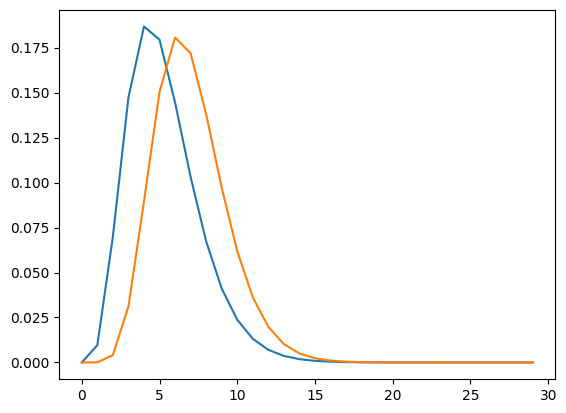

In [29]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [30]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [31]:
spec_radius = []
stability_criterion = []
which_eigvec = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))
    which_eigvec.append(np.argmax(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_], which_eigvec[_])

1.6118252056394802 8.0591260281974 1
1.9023787070447602 9.5118935352238 0
3.0624678907150122 8.0591260281974 1
1.6118252056394802 8.0591260281974 1


### Correct selection of the average generation time distribution

In [32]:
def compute_long_term_frac(r, gamma, serial_intervals, contact_matrix, transmissibility, which_eigvec):
    eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))
    integral = np.diagflat([scipy.integrate.quad(lambda x: si.pdf(x) * np.exp(-r * x), 0, 1000)[0] for si in serial_intervals])

    laplace_transform = gamma * np.matmul(eff_contact_matrix, integral)
    return np.linalg.eig(laplace_transform)[1][:, which_eigvec]

In [33]:
growth_rates = []

for _ in range(len(contact_matrix)):
    regression = scipy.optimize.curve_fit(f=lambda t, r: np.log(1+r) * t, xdata=times[150:]-times[149], ydata=np.log(agg_cases[_][150:])-np.log(agg_cases[_][149]), maxfev=1000)
    growth_rates.append(regression[0][0])

In [34]:
long_term_fracs = []

for _ in range(len(contact_matrix)):
    long_term_fracs.append(compute_long_term_frac(
        growth_rates[_], new_rs[_][-1], theoretical_serial_intervals, contact_matrix[_],
        transmissibility, which_eigvec[_]
    ))

In [35]:
average_serial_interval = []

for _ in range(len(contact_matrix)):
    sub_sum_i = 0
    for i in range(num_categories):
        sub_sum_j = 0
        for j in range(num_categories):
            sub_sum_j += serial_intervals[j, :] * contact_matrix[_][i, j] * transmissibility[j] * long_term_fracs[_][j]
        sub_sum_i += sub_sum_j

    average_serial_interval.append(sub_sum_i/(spec_radius[_]*np.sum(long_term_fracs[_])))

In [36]:
correc_i = []

for _ in range(len(contact_matrix)):
    # Same inference, but using the PoissonBranchProPosterior
    tau = 6
    R_t_start = tau+1
    a = 1
    b = 1/5
    sigma = 1.5

    # Correction for overall reproduction number
    # Imperfect contacts
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))
    correc_i.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

In [37]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2
    }))

## Divergence of Means

In [38]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval[_]):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval[_]) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[_][:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[_][:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval[_])
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                    sub_sum_j *= contact_matrix[_][i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multiple group versus One group model')

    fig.show_figure()

In [39]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed γ<sub>t</sub>', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Different generation time intervals, correct generation time', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis2=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis2=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis3=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis3=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis4=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis4=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_dif_SI_correct_GT.pdf')
fig.show()

## Parameterize example branching process model with disagregated data

In [40]:
# Build the generation time interval w_s
serial_intervals = []
theoretical_serial_intervals = []

ws_mean_cat = [5.3, 7]
ws_std_cat = [2.3, 2.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(30))

    serial_intervals.append(disc_w)

    theoretical_serial_intervals.append(w_dist)

serial_intervals = np.array(serial_intervals)

# Simulate incidence data
initial_r = 0.35

overall_reductions = [1, 0.75, 0.5, 0.8, 1, 0.75, 0.5]
times_reductions = [0, 20, 40, 100, 150, 170, 200]

contact_matrix = [
    np.array([[4, .4], [.6, 8.]]),
    np.array([[6, 8.], [4, .4]]),
    np.array([[4, .4], [.6, 8.]]),
    np.array([[4, .4], [.6, 8.]])
    ]

new_rs = [
    [0.35, 0.2],
    [0.35, 0.2],
    [0.35, 0.38],
    [0.35, 0.2]
    ]

parameters = [
    [50, 50],
    [50, 50],
    [50, 50],
    [20, 80],
    ]

transmissibility = [1, 1]

desagg_cases = []
agg_cases = []

for _ in range(len(contact_matrix)):
    m = branchpro.MultiCatPoissonBranchProModel(
        initial_r, serial_intervals, num_categories, contact_matrix[_], transmissibility, multipleSI=True)
    start_times = [0, 37]      # days at which each R_0 period begins
    m.set_r_profile(new_rs[_], start_times)
    times = np.arange(num_timepoints)

    desagg_cases.append(m.simulate(
        parameters[_], times, var_contacts=False,
        interventions=[np.diag([1, red]) for red in overall_reductions],
        time_interventions=times_reductions))
    agg_cases.append(np.sum(desagg_cases[_], axis=1))

    print(desagg_cases[_])

[[5.000e+01 5.000e+01]
 [0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00]
 [5.000e+00 3.000e+00]
 [1.100e+01 4.000e+00]
 [1.600e+01 1.400e+01]
 [1.600e+01 2.000e+01]
 [1.400e+01 2.100e+01]
 [1.400e+01 2.300e+01]
 [1.400e+01 2.800e+01]
 [2.000e+01 1.700e+01]
 [8.000e+00 3.300e+01]
 [2.200e+01 4.300e+01]
 [2.000e+01 3.700e+01]
 [2.100e+01 5.900e+01]
 [2.500e+01 5.200e+01]
 [2.700e+01 9.100e+01]
 [2.000e+01 7.000e+01]
 [3.200e+01 9.500e+01]
 [3.200e+01 7.100e+01]
 [3.000e+01 8.200e+01]
 [4.300e+01 8.800e+01]
 [3.300e+01 9.700e+01]
 [4.600e+01 1.450e+02]
 [7.100e+01 1.610e+02]
 [4.800e+01 1.580e+02]
 [5.400e+01 1.710e+02]
 [7.300e+01 1.790e+02]
 [6.800e+01 2.150e+02]
 [6.900e+01 2.100e+02]
 [8.900e+01 2.550e+02]
 [9.800e+01 3.100e+02]
 [1.070e+02 3.140e+02]
 [1.130e+02 3.480e+02]
 [1.320e+02 3.790e+02]
 [1.420e+02 4.290e+02]
 [1.510e+02 4.640e+02]
 [1.630e+02 5.310e+02]
 [1.120e+02 3.350e+02]
 [1.100e+02 2.530e+02]
 [1.290e+02 2.520e+02]
 [1.380e+02 2.800e+02]
 [1.350e+02 2.870e+02]
 [1.520e+02

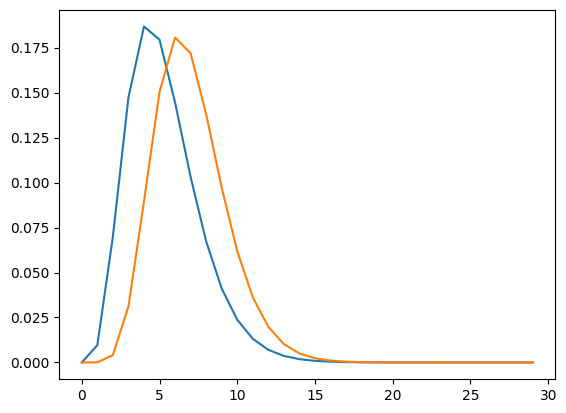

In [41]:
plt.plot(serial_intervals[0, :])
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [42]:
for _ in range(len(contact_matrix)):  
    # Plot (bar chart cases each day)
    fig = go.Figure()

    # Plot of incidences
    fig.add_trace(
        go.Bar(
            x=times,
            y=agg_cases[_],
            name='Incidences'
        )
    )

    # Add axis labels
    fig.update_layout(
        xaxis_title='Time (days)',
        yaxis_title='New cases'
    )

    fig.show()

In [43]:
spec_radius = []
stability_criterion = []
which_eigvec = []

for _ in range(len(contact_matrix)):    
    # Compute the eigenvalues of the maximum effective contact matrix
    eff_contact_matrix = np.matmul(contact_matrix[_], np.diag(transmissibility))

    spec_radius.append(np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix))))
    which_eigvec.append(np.argmax(np.absolute(np.linalg.eigvals(eff_contact_matrix))))

    # Compute stability criterion using last change in growth rate
    stability_criterion.append(new_rs[_][-1] * spec_radius[_])

    print(stability_criterion[_], spec_radius[_], which_eigvec[_])

1.6118252056394802 8.0591260281974 1
1.9023787070447602 9.5118935352238 0
3.0624678907150122 8.0591260281974 1
1.6118252056394802 8.0591260281974 1


### Correct selection of the average generation time distribution

In [44]:
growth_rates = []

for _ in range(len(contact_matrix)):
    regression = scipy.optimize.curve_fit(f=lambda t, r: np.log(1+r) * t, xdata=times[150:]-times[149], ydata=np.log(agg_cases[_][150:])-np.log(agg_cases[_][149]), maxfev=1000)
    growth_rates.append(regression[0][0])

In [45]:
long_term_fracs = []

for _ in range(len(contact_matrix)):
    long_term_fracs.append(compute_long_term_frac(
        growth_rates[_], new_rs[_][-1], theoretical_serial_intervals, contact_matrix[_],
        transmissibility, which_eigvec[_]
    ))

In [46]:
average_serial_interval = []

for _ in range(len(contact_matrix)):
    sub_sum_i = 0
    for i in range(num_categories):
        sub_sum_j = 0
        for j in range(num_categories):
            sub_sum_j += serial_intervals[j, :] * contact_matrix[_][i, j] * transmissibility[j] * long_term_fracs[_][j]
        sub_sum_i += sub_sum_j

    average_serial_interval.append(sub_sum_i/(spec_radius[_]*np.sum(long_term_fracs[_])))

In [47]:
average_serial_interval[0]

array([-0.00000000e+00,  5.51458287e-04,  7.55399484e-03,  3.72172984e-02,
        9.43809258e-02,  1.51745514e-01,  1.78530858e-01,  1.68092626e-01,
        1.34097518e-01,  9.41583560e-02,  5.97526025e-02,  3.49304955e-02,
        1.90796270e-02,  9.84378094e-03,  4.83792393e-03,  2.28028967e-03,
        1.03640024e-03,  4.56271639e-04,  1.95302128e-04,  8.15372662e-05,
        3.32929684e-05,  1.33267071e-05,  5.24049283e-06,  2.02819733e-06,
        7.73880382e-07,  2.91571731e-07,  1.08634861e-07,  4.00835085e-08,
        1.46671064e-08,  5.32984954e-09])

In [48]:
inc_data = []
ground_truth = []

for _ in range(len(contact_matrix)):
    # Transform our incidence data into pandas dataframes
    multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

    for _ in range(num_categories):
        multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
            desagg_cases[_][:, _]

    multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

    # Transform our incidence data into pandas dataframes
    inc_data.append(pd.DataFrame(
        {
            'Time': np.arange(num_timepoints),
            'Incidence Number': agg_cases[_]
        }
    ))

    L1 = len(np.arange(R_t_start, start_times[1]+1))
    L2 = len(np.arange(start_times[1]+1, num_timepoints))

    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': [new_rs[_][0]*correc_i[_]] * L1 + [new_rs[_][1]*correc_i[_]] * L2
    }))

## Divergence of Means

In [49]:
uni_post_dist = []
multi_post_dist = []

for _ in range(len(contact_matrix)):
    mean_ratios = []
    uni_rate = []
    multi_rate = []
    shape = []
    for t in np.arange(R_t_start, num_timepoints):
        shape.append( a + math.fsum(agg_cases[_][(t-tau):(t+1)]))
        uni_cat_sum_var = 0
        for k in range(t-tau,t+1):
            if k > len(average_serial_interval[_]):
                vec1 = agg_cases[_][(k-1):(k - len(average_serial_interval[_]) - 1):-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[_][:k] # w_1, ... , w_k
            else:
                vec1 = agg_cases[_][(k-1)::-1] # I_(k-1), ... , I_0
                vec2 = average_serial_interval[_][:k] # w_1, ... , w_k
            uni_cat_sum_var += math.fsum(np.multiply(vec1,vec2))/np.sum(average_serial_interval[_])
        uni_cat_rate = b + uni_cat_sum_var

        multi_cat_sum_var = 0
        for k_inx, k in enumerate(range(t-tau,t+1)):
            sub_sum_i = 0
            pos = np.where(np.asarray(times_reductions) <= t+1)
            current_npi = [np.diag([1, red]) for red in overall_reductions][pos[-1][-1]]
            for i in range(num_categories):
                for j in range(num_categories):
                    if k > serial_intervals.shape[1]:
                        vec1 = desagg_cases[_][(k-1):(k - serial_intervals.shape[1] - 1):-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    else:
                        vec1 = desagg_cases[_][(k-1)::-1, j] # I_(k-1), ... , I_0
                        vec2 = serial_intervals[j, :k] # w_1, ... , w_k
                    sub_sum_j = math.fsum(np.multiply(vec1,vec2))/np.sum(serial_intervals[j,:])
                    sub_sum_j *= np.matmul(current_npi, contact_matrix[_])[i, j] * transmissibility[j]
                    sub_sum_i += sub_sum_j
            multi_cat_sum_var += sub_sum_i  # vector of sum^k_{s=0} w_s I_{k-s}
            # print(multi_cat_sum_var)
        multi_cat_rate = b + (multi_cat_sum_var/spec_radius[_])

        mean_ratios.append(uni_cat_rate / multi_cat_rate)
        uni_rate.append(uni_cat_rate)
        multi_rate.append(multi_cat_rate)

    mean_ratio = pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': 100 * np.asarray(mean_ratios)
    })

    # Tests
    i + tau == num_timepoints
    len(shape) == num_timepoints - tau
    len(uni_rate) == num_timepoints - tau
    len(multi_rate) == num_timepoints - tau

    mean_uni = np.divide(shape, uni_rate)
    mean_multi = np.divide(shape, multi_rate)

    uni_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(uni_rate)))
    uni_post_dist_interval = uni_post_dist[_].interval(.95)

    multi_post_dist.append(scipy.stats.gamma(shape,scale = 1/np.array(multi_rate)))
    multi_post_dist_interval = multi_post_dist[_].interval(.95)

    fig = ReproductionNumberPlot()

    fig.add_ground_truth_rt(mean_ratio)    
    fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
    fig.figure.update_layout(title_text='Multiple group versus One group model')

    fig.show_figure()

In [50]:
subplot_titles = ['Original', 'Changed Contacts', 'Changed γ<sub>t</sub>', 'Changed ICs']

fig = go.Figure()
fig = make_subplots(rows=int(np.ceil(len(contact_matrix)/2)), cols=2, subplot_titles=tuple(subplot_titles))
# Plot (line plot for each age group and method of simulation)
for c in range(len(contact_matrix)):
    if c != 0:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )
    
    else:
        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='One-group model',
                line_color='deepskyblue'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=uni_post_dist[c].interval(.95)[1].tolist() + uni_post_dist[c].interval(.95)[0].tolist()[::-1],                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='deepskyblue',
                line_color='deepskyblue',
                opacity=0.3,
                mode='lines',
                name='One-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].mean(),
                x=np.arange(R_t_start, num_timepoints),
                mode='lines',
                name='Multiple-group model',
                line_color='red'
            ),
            row= int(np.floor(c / 2)) + 1,
            col= c % 2 + 1
        )

        fig.add_trace(
            go.Scatter(
                y=multi_post_dist[c].interval(.95)[1].tolist() + multi_post_dist[c].interval(.95)[0].tolist()[::-1],
                x=np.arange(R_t_start, num_timepoints).tolist() + np.arange(R_t_start, num_timepoints).tolist()[::-1],
                fill='toself',
                fillcolor='red',
                line_color='red',
                opacity=0.3,
                mode='lines',
                name='Multiple-group model',
                showlegend=False
            ),
            row= int(np.floor(c / 2)) + 1,
                col= c % 2 + 1
        )

# Add axis labels
fig.update_layout(
    boxmode='group',
    title='Same generation time interval', 
    width=700,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis2=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis2=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis3=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis3=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    xaxis4=dict(
        title='Time (days)',
        linecolor='black'),
    yaxis4=dict(
        title='Reproduction number R<sub>t</sub>',
        linecolor='black', range=[0, 8.7]),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ))

fig.write_image('images/Comparison_diff_SI_correct_GT_changing conditions.pdf')
fig.show()